In [19]:
from datetime import datetime, timedelta
from pathlib import Path

import numpy as np
import rasterio as rio
from matplotlib import pyplot as plt
from pyproj import Transformer
from pystac_client import Client
from rasterio.io import MemoryFile
from rasterio.warp import Resampling, reproject
from rasterio.windows import from_bounds


In [ ]:
ENDPOINT = 'https://earth-search.aws.element84.com/v1' # Any STAC API endpoint will work here
PROD_COLLECTION = 'sentinel-2-c1-l2a' # If we do change endpoint, we will need verify what collections are available
# Turns out the above has been depricated in favor of sentinel-2-c1-l2a, which will NOT have offsets applied
QA_PERCENT = 5  # Later on we will be looking at the SCL (quality) band, this is the threshold used for rejection
TARGET_DIR = Path('datasets/yields') # Targets in this context refers to the yield data, as they form the target for the model
OUTPUT_DIR = Path('datasets/sentinel-c1') # Directory where the processed Sentinel-2 data will be stored

# We can refactor to process all crops at once, or a list thereof if desired
# IIRC naming doesn't even depend on this, and checks the target raster
# crop = 'SOYBEANS'

# We want the 10m bands
# These correspond to the naming under 'assets' in the STAC items
# Equivalent to B04, B03, B02, B08, which will show on the filenames
bands = ['red', 'green', 'blue', 'nir']

In [40]:
def get_crop(filename):
    return filename.split('_')[0]

def get_yeardate(filename):
    return filename.split('_')[2]

def get_year(filename):
    return get_yeardate(filename)[0:4]

def get_date(filename):
    return get_yeardate(filename)[4:]

def get_bbox(raster):
    with rio.open(raster) as src:
        return src.bounds
    
def get_crs(raster):
    with rio.open(raster) as src:
        return src.crs

In [50]:
# Check for existance of TARGET_DIR
if not TARGET_DIR.exists():
    raise FileNotFoundError(f'{TARGET_DIR} does not exist')

# Create OUTPUT_DIR if it does not exist
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Get a list of the yield rasters for the given crop
yields = list(TARGET_DIR.glob('*.tif'))
# yields = [y for y in yields if crop == get_crop(y.name)]

In [42]:
def get_first_candidate_below_threshold(candidates, bbox, crs, threshold):
    """
    Get the first candidate that has a cloud percentage below the threshold (percent).
    Candidates are STAC items.

    Args:
        candidates: List of STAC items.
        bbox: Bounding box.
        crs: CRS of the yield raster.
        threshold: Maximum cloud percentage.
        
    Returns: 
        STAC item corresponding to the first candidate below the threshold if found, None otherwise.
    """
    for candidate in candidates:
        scl = candidate.assets['scl']
        scl_href = scl.href

        with rio.open(scl_href) as src:
            # Check crs against yield raster
            assert src.crs == crs

            # Get the window for the bbox
            window = from_bounds(*bbox, src.transform)
            scl_data = src.read(1, window=window)

            # Sum 0, 1, 3, 8, 9, 10 pixels
            # 0: No data
            # 1: Saturated or defective
            # 3: Cloud shadows
            # 8: Cloud medium probability
            # 9: Cloud high probability
            # 10: Thin cirrus
            cloud_pixels = np.sum(np.isin(scl_data, [0, 1, 3, 8, 9, 10]))
            cloud_prc = cloud_pixels / scl_data.size * 100

            if cloud_prc < threshold:
                return candidate
            
    return None


In [43]:
def get_bands(candidate, bands, bbox, crs, to_float=False):
    """
    Get the bands for the given candidate.

    Args:
        candidate: Candidate STAC item.
        bands: List of bands to fetch.
        bbox: Bounding box.
        crs: CRS of the yield raster.
        to_float: Whether to return the bands as float32.
        
    Returns:
        Memfile with the band data.
    """
    memfile = rio.io.MemoryFile()

    # Get the first band to set up the profile
    band = bands[0]
    asset = candidate.assets[band]
    band_href = asset.href

    with rio.open(band_href) as src:
        # Check crs against yield raster
        # Might want to relax this in the future
        assert src.crs == crs

        # Get the window for the bbox
        # and update the profile
        window = from_bounds(*bbox, src.transform)
        transform = src.window_transform(window)
        profile = src.profile.copy()
        profile.update(count=len(bands),
                       height=window.height,
                       width=window.width,
                       transform=transform)
        
        if to_float:
            profile.update(dtype='float32')

        # Save the bands to the memfile
        with memfile.open(**profile) as dst:
            for i, band in enumerate(bands, start=1):
                asset = candidate.assets[band]
                band_href = asset.href

                with rio.open(band_href) as src:
                    band_data = src.read(1, window=window)
                    if to_float:
                        band_data = band_data.astype('float32')
                    dst.write(band_data, i)

    return memfile



In [44]:
def match_raster_and_mask(target, mask, output_path=None, resampling_method=Resampling.bilinear):
    """
    Take our bands and reporject, resample, crop, and mask them to match the mask (target/yield) raster.

    Args:
        target: Path to the target raster.
        mask: Path to the mask/target/yield raster.
        output_path: Path to save the output raster. If none is given, an in-memory file is used.
        resampling_method: Resampling method to use when reprojecting the bands.

    Returns:
        Path to the output raster if output_path is given, otherwise a MemoryFile.
    """
    with rio.open(mask) as ref:
        ref_crs = ref.crs
        ref_transform = ref.transform
        ref_width, ref_height = ref.width, ref.height
        mask_data = ref.read(1)
        mask_nodata = ref.nodata if ref.nodata is not None else 0

    with rio.open(target) as src:

        # Update metadata
        new_meta = src.meta.copy()
        new_meta.update({
            "crs": ref_crs,
            "transform": ref_transform,
            "width": ref_width,
            "height": ref_height,
            # Use 0 as nodata for integer types
            # and the mask nodata value for float32
            "nodata": mask_nodata if src.dtypes[0] == 'float32' else 0
        })

        # Use in-memory file if no output path is given
        if output_path is None:
            memfile = MemoryFile()
            output = memfile.open(**new_meta)
        else:
            memfile = None
            output = rio.open(output_path, "w", **new_meta)

        with output as dst:
            for i in range(1, src.count + 1):
                # Reproject band
                band_data = np.zeros((ref_height, ref_width), dtype=src.dtypes[i - 1])
                reproject(
                    source=rio.band(src, i),
                    destination=band_data,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=ref_transform,
                    dst_crs=ref_crs,
                    resampling=resampling_method
                )

                # Apply mask
                # This can easily be made toggleable
                band_data = np.where(np.isclose(mask_data, mask_nodata), output.nodata, band_data)

                # Write to output
                dst.write(band_data, i)

        return memfile if memfile else output_path

In [51]:
client = Client.open(ENDPOINT)

# Bonus points to anyone who can guess why this isn't just named 'yield'
for yield_raster in yields:

    year = get_year(yield_raster.stem)
    date = get_date(yield_raster.stem)

    print(f'Processing {yield_raster.stem} from {year} {date}')

    # Convert the julian date and year to a datetime object
    harvest_date = datetime.strptime(f'{year} {date}', '%Y %j')
    begin_search_date = harvest_date - timedelta(days=28)
    # Looks like some harvest dates might be off, to be safe, we end the search
    # a few days before the harvest date.
    end_search_date = harvest_date - timedelta(days=2)

    # The STAC client requires the bounding box in lat/lon
    crs = get_crs(yield_raster)
    transformer = Transformer.from_crs(crs, 'epsg:4326')
    bbox = get_bbox(yield_raster)
    # WARNING: transform takes x, y but returns y, x as we go from epsg:326XX to epsg:4326
    # Check the related WKTs to see the order of the coordinates
    min_lat, min_lon = transformer.transform(bbox.left, bbox.bottom)
    max_lat, max_lon = transformer.transform(bbox.right, bbox.top)
    # The bbox order for search is [minx, miny, maxx, maxy]
    bbox_latlon = [min_lon, min_lat, max_lon, max_lat]

    search = client.search(
        collections=[PROD_COLLECTION],
        datetime=f"{begin_search_date.date()}/{end_search_date.date()}",
        bbox=bbox_latlon,
        query={
            "proj:epsg": {"eq": crs.to_epsg()}
            },
        sortby=[{"field": "properties.datetime", "direction": "desc"}],     # Most recent first
        max_items=50
    )

    candidates = list(search.items())

    candidate = get_first_candidate_below_threshold(candidates, bbox, crs, QA_PERCENT)

    if candidate is None:
        print('No candidate found below threshold')
        continue

    print(f'Candidate found: {candidate.id}')

    # Get the bands
    stack = get_bands(candidate, bands, bbox, crs, to_float=True)

    # Crop, mask, and reproject stack
    output = OUTPUT_DIR / yield_raster.name

    if output.exists():
        print(f'{output} already exists, skipping')
        continue

    match_raster_and_mask(stack, yield_raster, output)

    print(f'Output saved to {output}')

Processing BARLEY_3b082971-14a8-478d-9f9b-d0610e8a4d0b_2016221 from 2016 221
No candidate found below threshold
Processing BARLEY_3b082971-14a8-478d-9f9b-d0610e8a4d0b_2019217 from 2019 217
Candidate found: S2B_T14UPA_20190730T173355_L2A
Output saved to datasets\sentinel-c1\BARLEY_3b082971-14a8-478d-9f9b-d0610e8a4d0b_2019217.tif
Processing BARLEY_522167a4-0000-1000-4037-e1e1e1319100_2021210 from 2021 210
Candidate found: S2A_T14UPA_20210714T173115_L2A
Output saved to datasets\sentinel-c1\BARLEY_522167a4-0000-1000-4037-e1e1e1319100_2021210.tif
Processing BARLEY_53774847-0000-1000-7f86-e1e1e1189410_2022256 from 2022 256
No candidate found below threshold
Processing BARLEY_55460684-0000-1000-7fb6-e1e1e1189410_2015215 from 2015 215
No candidate found below threshold
Processing BARLEY_55460684-0000-1000-7fb6-e1e1e1189410_2017225 from 2017 225
No candidate found below threshold
Processing BARLEY_8c47940c-54f2-4bb9-af27-2f48d9ac96f8_2022256 from 2022 256
No candidate found below threshold
Proc

In [12]:
candidate

<Item id=S2A_14UPA_20200818_1_L2A>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.65897095..1.0].


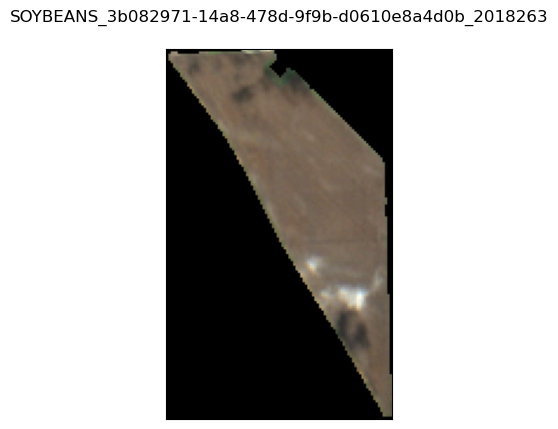

In [30]:
path = OUTPUT_DIR / 'SOYBEANS_3b082971-14a8-478d-9f9b-d0610e8a4d0b_2018263.tif'

# fig, ax = plt.subplots(dpi=300, figsize=(8, 8))
fig, ax = plt.subplots()

with rio.open(path) as src:
    # Read the first three bands (R, G, B)
    # and stack them together
    r = src.read(1)
    g = src.read(2)
    b = src.read(3)
    rgb = np.dstack((r, g, b))

    # Normalize the RGB image to the range [0, 1] for display
    # Ignore the message about clipping, the negative values are due to the nodata value
    rgb = rgb / rgb.max(axis=(0,1))
    
    im = ax.imshow(rgb)
    
    # Create the color bar (optional, not typically used for RGB images)
    # cbar = plt.colorbar(im, ax=ax, shrink=0.7)
    # cbar.set_label('Scaled Reflectance')
    
    # Set the title
    ax.set_title(path.stem, pad=20)
    
    # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()